# PROBA-V Super Resolution Challenge

PROBA-V Super Resolution challenge is an image super resolution task, aiming to construct super resolution (sr) images from multiple low resolution (lr) images for given scenes. Images for different scenes are all collected by an earth observation satellite called PROBA-V. Each image comes with a corresponding quality map, indicating which pixels are concealed (i.e. clouds covering, missing, etc) and which pixels should be considered clear. For every scene in training dataset, there are multiple low resolution (lr) images (size 128*128), corresponding quality maps, one target high resolution (hr) image (size 384*384) and its corresponding quality map. In test datasets, the target high resolution images are unavailable. We want to reconstruct the missing high resolution images (called super resolution images) from multiple lr images on the test dataset.

For this task, we can design a neural network that takes low resolution images as training data and target high resolution images as labels for training data. These mappings between the low resolution image and the high resolution image under the same scene are expected to be learned by the neural network. In such a way, for a given low resolution image, we can predict its reconstructed super resolution image by feeding it as the input to the trained neural network.  

Speical things needed to be carefully considered:
1. The size of low resolution images (and corresponding quality maps) and high resolution images (and their quality maps) are different. We need to upscale low resolution images and their quality maps to match the size of high resolution images.
2. The training data is not enough if counting each scene as one training example. Also, the number of low resolution images in every scene are variant. Considering the two issues, the high resolution image in every scene is augmented to match every low resolution image under the same scene. For example, if a scene contains 10 low resolution images and 1 high resolution image, we copy the same high resolution image for 10 times to make them as pairs of the 10 low resolution images. Each time, we feed the neural network with one lr and one corresponding hr image. 
3. We need to find a neural network that can take one image as input and another image as output. In this task, we use U-net as such a network structure.  
4. According to the requirement of the task, only clear pixels should be considered in the computation. So we need to modify the loss function in model training, summarizing only the loss of clear pixels indicated by quality maps of the target high resolution images.

Another non-deep learning based solution: 

Tensor/matrix completion is another possible solution for this task. Missing values of upscaling lr to sr images can be infered from other neighbor pixels in one image and other images from the same scene. This approach is model-free and does not need to know the hr images. In this task, we only attempt to implement the previous deep learning-based approach. 

## Get started

In [4]:
# Import necessary libraries and envs
import matplotlib.pylab as plt
import seaborn as sns
from helper import *
from unet import *
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from skimage import io
from PIL import Image

In [5]:
DATA_PATH = 'probav_data/'

train = all_scenes_paths(DATA_PATH + 'train')
test  = all_scenes_paths(DATA_PATH + 'test')

print("The number of training scenes is", len(train))
print("The number of test scenes is", len(test))
print("The number of total scenes is", len(train) + len(test))

The number of training scenes is 1160
The number of test scenes is 290
The number of total scenes is 1450


The type and shape of low resolution images is uint16 (128, 128)
The type and shape of high resolution images is uint16 (384, 384)


/home/ubuntu/anaconda3/envs/thesis/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


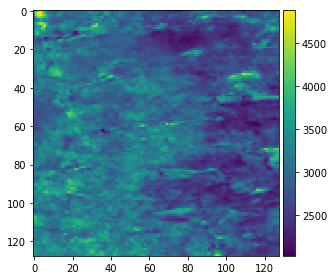

In [9]:
# Read a lr and hr image and check their types and shapes
lr = skimage.io.imread('probav_data/train/RED/imgset0000/LR012.png')
hr = skimage.io.imread('probav_data/train/RED/imgset0000/HR.png')

print("The type and shape of low resolution images is", lr.dtype.name, lr.shape)
print("The type and shape of high resolution images is", hr.dtype.name, hr.shape)
io.imshow(lr)

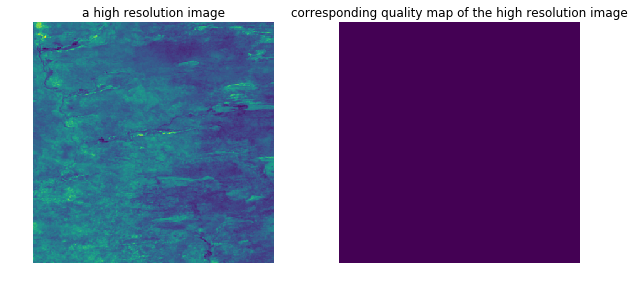

In [7]:
# Visualize a high resolution image the its corresponding quality map
hr, sm = highres_image(DATA_PATH + 'train/RED/imgset0000')
fig = plt.figure(figsize=(9, 9))
ax1 = fig.add_subplot(121); ax1.imshow(hr); ax1.axis('off'); ax1.set_title('a high resolution image')
ax2 = fig.add_subplot(122); ax2.imshow(sm); ax2.axis('off'); ax2.set_title('corresponding quality map of the high resolution image')
plt.tight_layout()

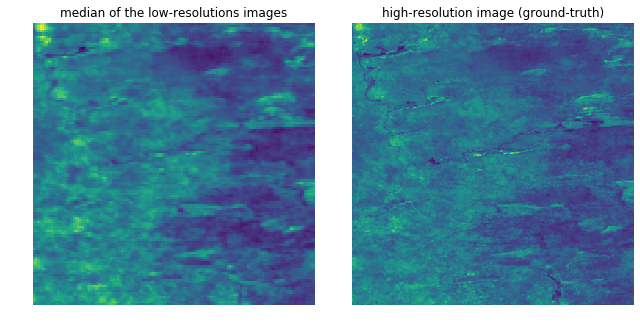

In [10]:
# Aggregate multiple lr images by taking median pixels, show the aggregated lr image and the hr image in the same scene
scene = DATA_PATH + 'train/RED/imgset0000'

ag = central_tendency(scene, agg_with='median', only_clear=True)

hr = highres_image(scene)[0]

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(121); ax1.imshow(ag); ax1.axis('off'); ax1.set_title('median of the low-resolutions images')
ax2 = fig.add_subplot(122); ax2.imshow(hr); ax2.axis('off'); ax2.set_title('high-resolution image (ground-truth)')
plt.tight_layout()

## Data preprocessing and data loading

In this section, we prepare the dataset class for loading data in a PyTorch dataloader. The training data is loaded as the shape (batch_size, num_channels, image size) and in our case, it is (16, 2, 384, 384). Note that firstly we upscale both lr images and their quality maps and secondly we stack the two as a channel-2 image input. In the class, we return both hr images and their corresponding quality maps. Hr images are used as the label/output of the neural network. The quality maps of hr images are used in the training loss function as indicating which pixels of the image are concealed in computing the training loss. Batch size is adopted as 16, the maximum value for fitting the memory of a computing server.

In [2]:
# Write a dataset class for pytorch dataloader

class ProbavData(Dataset):

    def __init__(self, folder_dataset, train=None, transform=None):
        self.transform = transform
        self.train = train
        
        # Training dataset
        if self.train:
            self.__xs = []
            self.__ys = []
            # All scene path for training dataset
            train = all_scenes_paths(folder_dataset + 'train')
            for i in range(len(train)):
                path = train[i]
                path = path if path[-1] in {'/', '\\'} else (path + '/')
                for f in glob(path + 'LR*.png'):
                    q = f.replace('LR', 'QM')
                    lr = np.stack((f, q))
                     # Lr image path
                    self.__xs.append(lr)
                     # Hr image path
                    hr = np.stack((path + 'HR.png', path + 'SM.png'))
                    self.__ys.append(hr)

        # Test dataset
        else:
            self.__xs_test = []
            self.__ymask_test = []
            # All scene path for test dataset
            test  = all_scenes_paths(folder_dataset + 'test')
            for i in range(len(test)):
                path = test[i]
                # Test lr image path
                self.__xs_test.append(path)

    # Override to give PyTorch access to any image on the dataset
    def __getitem__(self, index):

        if self.train:
            # Read lr, lr quality map, hr and hr quality map images
            lr = skimage.io.imread(self.__xs[index][0])
            lr_mask = skimage.io.imread(self.__xs[index][1], dtype=np.bool)
            hr = skimage.io.imread(self.__ys[index][0])
            hr_mask = skimage.io.imread(self.__ys[index][1], dtype=np.bool)

            lr = skimage.img_as_float(lr)
            lr = lr.astype(np.float32)
            # Upscale lr images
            lr = lr.repeat(3, axis = 0).repeat(3, axis = 1)
            lr_mask = lr_mask*1
            # Upscale the lr quality maps 
            lr_mask = lr_mask.repeat(3, axis = 0).repeat(3, axis = 1)
            lr_reshape = lr.reshape(1, 384, 384)
            lr_mask = lr_mask.reshape(1, 384, 384)
            # Stack lr images and the quality maps as a 2 channel input
            image = np.vstack((lr_reshape, lr_mask))
            
            hr = skimage.img_as_float(hr)
            hr = hr.astype(np.float32)
            hr = hr.reshape(1, 384, 384)
            hr = torch.from_numpy(np.asarray(hr))
            hr = hr.type(torch.FloatTensor)
            hr_mask = hr_mask*1
            hr_mask = hr_mask.reshape(1, 384, 384)

            if self.transform is not None:
                img = self.transform(img)

            # Convert image and label to torch tensors
            image = torch.from_numpy(np.asarray(image))
            image = image.type(torch.FloatTensor)

            hr_mask = torch.from_numpy(np.asarray(hr_mask))
            hr_mask = hr_mask.type(torch.FloatTensor)

        else:
            # Aggregate multiple lr images in test dataset
            lr = central_tendency(self.__xs_test[index], agg_with='median', only_clear=True)
            lr = lr.astype(np.float32)
            # Upscale the lr images
            lr = lr.repeat(3, axis = 0).repeat(3, axis = 1)
            lr_reshape = lr.reshape(1, 384, 384)
            # Write a quality map filled with 1.
            lr_mask = np.ones(147456).reshape(1, 384, 384)
            image = np.vstack((lr_reshape, lr_mask))
            # Convert image and label to torch tensors
            image = torch.from_numpy(np.asarray(image))
            image = image.type(torch.FloatTensor)

        if self.train:
            return image, hr, hr_mask

        else:
            return image

    # Override to give PyTorch size of dataset
    def __len__(self):
        if self.train:
            return len(self.__xs)
        else: 
            return len(self.__xs_test)

In [3]:
train_dataset = ProbavData(folder_dataset = 'probav_data/', train=True)
test_dataset = ProbavData(folder_dataset = 'probav_data/', train=False)

# Data loader for training dataset and test dataset
data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=16,
                                          num_workers=0,
                                          drop_last=True,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          num_workers=0,
                                          drop_last=True,
                                          shuffle=False)

## Building a U-net
In this section, we use a U-net model to learn the mapping between lr images and hr images. U-net is a convolutional network structure originally used in biomedical image segmentation. This U-shaped architecture can be trained from end-to-end, which takes images as its inputs and outputs. 

The input of U-net is a 2-channeled image (a 1-channeled lr image and its corresponding quality map) and the output/label is the 1-channeled hr image. Quality maps of hr images are used as weights to compute a weighted mean squared error training loss. This loss ensures the concealed pixels in hr images are not involved in the network training procedure. Adam is used as the network optimizer with a learning rate of 0.01. 

In [11]:
def build_model():   
    net = UNet(2, 1)
    if torch.cuda.is_available():
        net.cuda()
    #opt = torch.optim.SGD(net.parameters(),lr=0.01, momentum=0.9, weight_decay=0.0005)
    opt = torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
    return net, opt

# A weighted mean squared error loss
def weighted_mse_loss(input,target,weights):
    out = (input-target)**2
    out = out * weights
    loss = out.mean()
    return loss      

## Training U-Net
Before training the U-net, we call the previously defined model and the optimizer. Then, we load training data in mini-batches and train the model. The code for training the model is prepared separately as a .py file for running in the remote computing server. After the training procedure finishes, we save the model for the later use in prediction. 

In [ ]:
# Build the model
net, opt = build_model()

# Train U-net
for epoch in tqdm(range(50)):
    print('Starting epoch {}/{}.'.format(epoch + 1, 50))

    net.train()
    epoch_loss = 0

    for i, (image, label, label_mask) in enumerate(data_loader):
        
        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            label_mask = label_mask.cuda()

        pred = net(image)
        probs_flat = pred.view(-1)
        true_flat = label.view(-1)
        label_mask = label_mask.view(-1)
        loss = weighted_mse_loss(probs_flat, true_flat, label_mask)
        epoch_loss += loss.item()

        opt.zero_grad()
        loss.backward()
        opt.step()

    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))
    
# Save the model
torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': opt.state_dict()
            }, "/home/tongtong/result/lr0.01bs16wd0.0num_epoch50.pt")

## Model prediction / Super resolution image reconstruction

In the following, we import the saved trained model and predict the super resolution images from the low resolution test images. We aggregate the multiple images under the same scene and use the aggregated image as the input to predict the super resolution image for this scene.

In [ ]:
net, opt = build_model()
net.load_state_dict(torch.load("result/lr0.01bs16wd0.0num_epoch50.pt")["model_state_dict"])

net.eval()

# Predict on test data
for i, image in enumerate(test_loader):
    
    if torch.cuda.is_available():
        image = image.cuda()

        output = net(image)
        output= np.array(output.detach()).reshape(384, 384)
        io.imsave('./result/imgset{}.png'.format(i+1160), output)


## Results
We compare the low resolution images and the reconstructed super solution image for some selected test scenes. As clearly be seen, the reconstructed sr images are better in resolution than the lr images and reveals more geographical details as compared with lr images. 

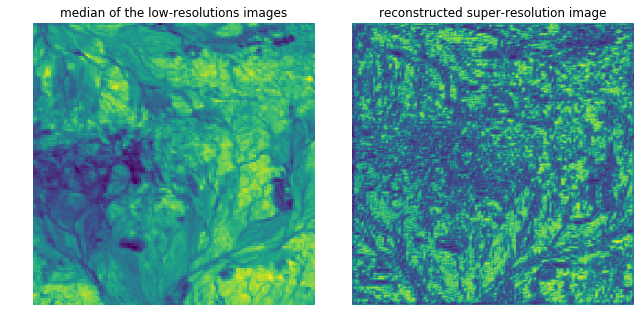

In [39]:
# Compare low resolution image with the reconstructed super resolution image in the same scene
scene = DATA_PATH + 'test/RED/imgset1172'
output = np.array(Image.open('./result/imgset1172.png')) 
ag = central_tendency(scene, agg_with='median', only_clear=True)

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(121); ax1.imshow(ag); ax1.axis('off'); ax1.set_title('median of the low-resolutions images')
ax2 = fig.add_subplot(122); ax2.imshow(output); ax2.axis('off'); ax2.set_title('reconstructed super-resolution image')
plt.tight_layout()

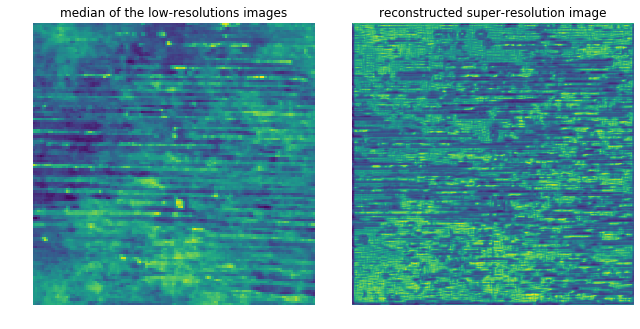

In [34]:
# Compare low resolution image with the reconstructed super resolution image in the same scene
scene = DATA_PATH + 'test/RED/imgset1160'
output = np.array(Image.open('./result/imgset1160.png')) 
ag = central_tendency(scene, agg_with='median', only_clear=True)

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(121); ax1.imshow(ag); ax1.axis('off'); ax1.set_title('median of the low-resolutions images')
ax2 = fig.add_subplot(122); ax2.imshow(output); ax2.axis('off'); ax2.set_title('reconstructed super-resolution image')
plt.tight_layout()

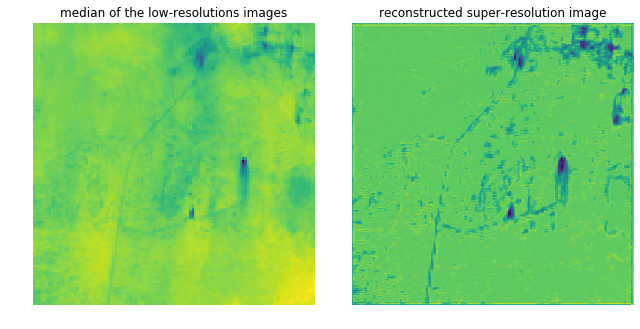

In [35]:
# Compare low resolution image with the reconstructed super resolution image in the same scene
scene = DATA_PATH + 'test/NIR/imgset1308'
output = np.array(Image.open('./result/imgset1308.png')) 
ag = central_tendency(scene, agg_with='median', only_clear=True)

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(121); ax1.imshow(ag); ax1.axis('off'); ax1.set_title('median of the low-resolutions images')
ax2 = fig.add_subplot(122); ax2.imshow(output); ax2.axis('off'); ax2.set_title('reconstructed super-resolution image')
plt.tight_layout()

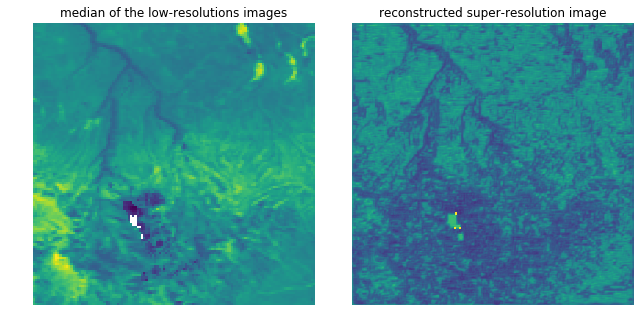

In [36]:
# Compare low resolution image with the reconstructed super resolution image in the same scene
scene = DATA_PATH + 'test/NIR/imgset1315'
output = np.array(Image.open('./result/imgset1315.png')) 
ag = central_tendency(scene, agg_with='median', only_clear=True)

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(121); ax1.imshow(ag); ax1.axis('off'); ax1.set_title('median of the low-resolutions images')
ax2 = fig.add_subplot(122); ax2.imshow(output); ax2.axis('off'); ax2.set_title('reconstructed super-resolution image')
plt.tight_layout()

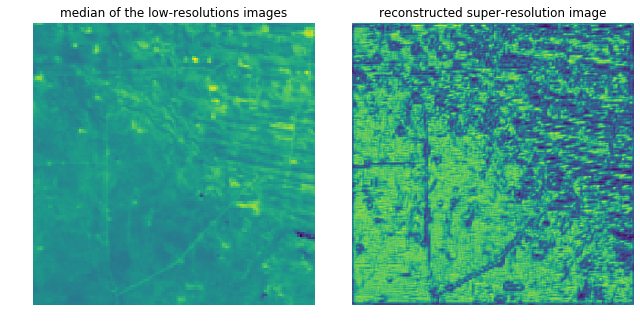

In [16]:
# Compare low resolution image with the reconstructed super resolution image in the same scene
scene = DATA_PATH + 'test/NIR/imgset1322'
output = np.array(Image.open('./result/imgset1322.png')) 
ag = central_tendency(scene, agg_with='median', only_clear=True)

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(121); ax1.imshow(ag); ax1.axis('off'); ax1.set_title('median of the low-resolutions images')
ax2 = fig.add_subplot(122); ax2.imshow(output); ax2.axis('off'); ax2.set_title('reconstructed super-resolution image')
plt.tight_layout()

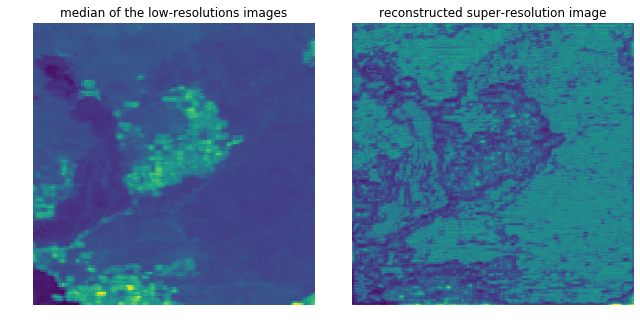

In [25]:
# Compare low resolution image with the reconstructed super resolution image in the same scene
scene = DATA_PATH + 'test/NIR/imgset1331'
output = np.array(Image.open('./result/imgset1331.png')) 
ag = central_tendency(scene, agg_with='median', only_clear=True)

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(121); ax1.imshow(ag); ax1.axis('off'); ax1.set_title('median of the low-resolutions images')
ax2 = fig.add_subplot(122); ax2.imshow(output); ax2.axis('off'); ax2.set_title('reconstructed super-resolution image')
plt.tight_layout()